In [1]:
# Import PyTorch Data Loader Library
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.models.segmentation import fcn_resnet50, fcn_resnet101

# Other Library Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchmetrics import Dice

# Custom Imports
from DRAC_Dataloading import DRAC_Loader
from DRAC_Models import ResNetBinary
from DRAC_Training import train_model
from DRAC_Testing import test_model
from DRAC_Criterion import DiceLoss

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
torch.__version__

'2.0.1'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

cuda:0
NVIDIA RTX A5000


In [4]:
## Default Variables ##
# Datasets #


# Dataloader #
batch_size = 1 # Batch size of 16

# Model #
model = fcn_resnet50(pretrained=False)
model.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.classifier[4] = nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
model_name = 'fcn_resnet50'

#criterion = Dice(num_classes=2).to(device)
#criterion_name = 'DICEtorch'
criterion = nn.CrossEntropyLoss()
criterion_name = 'CrossEntropyLoss'
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 250

In [5]:
# Key Data Locations
# Select 'train' or 'test' data.
datasets =[DRAC_Loader(data_type = 'train', transform = None, mask = "intraretinal"),
          DRAC_Loader(data_type = 'train', transform = None, mask = "neovascular"),
          DRAC_Loader(data_type = 'train', transform = None, mask = "nonperfusion")]

In [6]:
loaders = [DataLoader(datasets[0], batch_size=batch_size, shuffle=True),
           DataLoader(datasets[1], batch_size=batch_size, shuffle=True),
           DataLoader(datasets[2], batch_size=batch_size, shuffle=True)]

In [7]:
# Look at image dimension in dataset
image, mask = datasets[0][0]
image.shape, mask.shape

(torch.Size([1, 1024, 1024]), torch.Size([1024, 1024]))

In [8]:
loader_names = ['Intraretinal', 'Neovascularization', 'Nonperfusion']

folder = f'models/{model_name}_{batch_size}_{epochs}_{criterion_name}'

def createModelFolder(directory):
    # Check to see if the folder exists, if not, create it. If it does, cycle through number interations until a new folder is created.
    if not os.path.exists(directory):
        os.makedirs(directory)
    else:
        i = 1
        while os.path.exists(f'{directory}_{i}'):
            i += 1
        folder = f'{directory}_{i}'
        os.makedirs(directory)
        
    return folder

all_losses = []
count = 0
create = False
for train_loader in loaders:
    model, loss = train_model(model, train_loader, criterion, optimizer, epochs=epochs, criterion_name=criterion_name, segmentation_name=loader_names[count])
    count += 1

    if create:
        folder = createModelFolder(folder)
        create = False
    
    path_location = f'{folder}/{loader_names[loaders.index(train_loader)]}.pth'
    
    # Save the model
    torch.save(model.state_dict(), path_location)
    all_losses.append(loss)

[Epoch 1/250] Intraretinal - Loss: 0.0662 | Time Spent: 17.56s
[Epoch 2/250] Intraretinal - Loss: 0.0327 | Time Spent: 17.50s
[Epoch 3/250] Intraretinal - Loss: 0.0282 | Time Spent: 17.66s


KeyboardInterrupt: 

In [ ]:
# Checks to see if graphs folder exists #
if not os.path.exists('graphs'):
    os.makedirs('graphs')

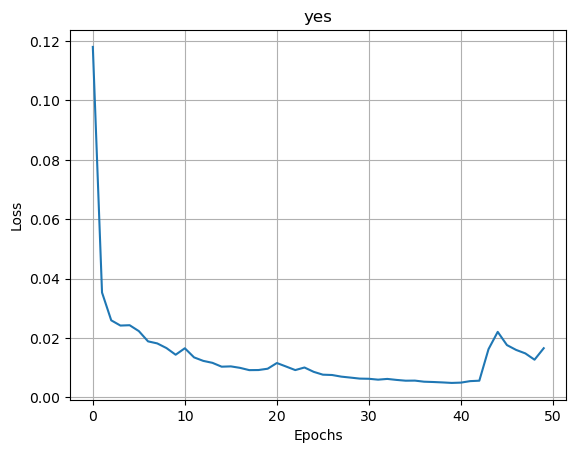

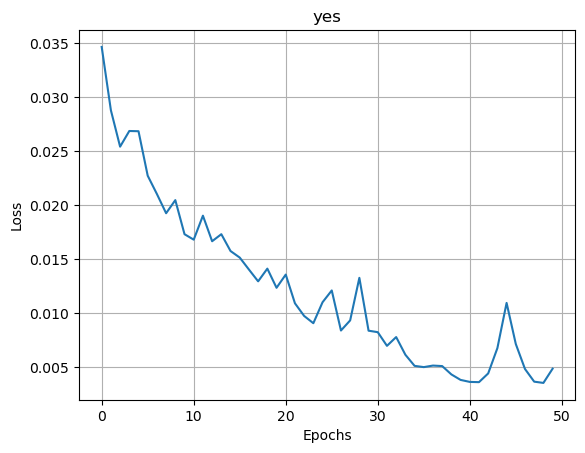

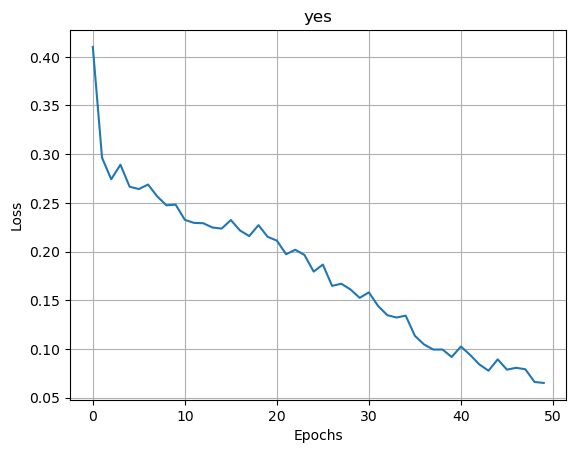

In [ ]:
# Plot the loss
plot = True
for loss in all_losses:
    name = "yes"
    plt.plot(loss)
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()